# Image Classification with Convolution Neural Network (CNN)

## Table of Contents
---
###1. MNIST Dataset
- Simple CNN w/ $k$-fold cross validation

###2. Kaggle Dataset
- ResNet and DenseNet from scratch
- Transfer learning (fine-tuning and feature extractor)

###3. References

#1. MNIST Dataset 

- ## Simple CNN with $k$-fold cross validation. (just learned in previous session)

- ## All you need is to do followings:
    1. Construct dataset and dataloader - **takes many many times for building custom datasets!**
    2. Build a model.
    3. Set the hyperparameters (the number of epochs, learning rate, optimizer, etc.)
    4. Train and evaluate the model.

In [ ]:
# Import libraries to use for Deep Learning 

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

import torchvision
from torchvision import datasets, transforms
from torchvision.io import read_image
from torchsummary import summary

import matplotlib.pyplot as plt

## 1. Construct dataset and dataloader 

- Simply, we will see a simple dataset - MNIST.
- Torchvision provides multiple built-in datasets on image classification, Object detection, segmentation, etc.
    - i.e., MNIST, CIFAR-10, etc.
- Further information on PyTorch dataset, please refere [here](https://pytorch.org/vision/stable/datasets.html).
- We will use scikit-learn library for $k$-fold cross validation. 
    - Please refer [here](https://scikit-learn.org/stable/modules/cross_validation.html) for details.

In [ ]:
'''
Construct dataset

- torchvision.datasets.MNIST provides train and test datasets.
- you can simply split train dataset into train and validation set using 
  torch.utils.data.random_split(DATASET, LENGTHS), but
- we will use 5-fold cross validation in MNIST dataset using scikit-learn library.
- also, we will use normalization only in this example.
'''

dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_dataset = datasets.MNIST('../data', train=False, download=True,
                    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
from sklearn.model_selection import KFold

# if random_state is None (which is default), then you will get different indices while spliting. 

kfold = KFold(n_splits=5, shuffle=True, random_state=12345) 
# kfold = KFold(n_splits=5, shuffle=True, random_state=None) 
# kfold = KFold(n_splits=5, shuffle=False) 

for fold, (train_idx, valid_idx) in enumerate(kfold.split(dataset)):
    print(f'Fold {fold}, first 5 train indices are {train_idx[:5]} and first 5 validation indices are {valid_idx[:5]}')

Fold 0, first 5 train indices are [0 1 2 3 4] and first 5 validation indices are [ 5 14 18 33 41]
Fold 1, first 5 train indices are [0 3 4 5 6] and first 5 validation indices are [ 1  2  8 15 23]
Fold 2, first 5 train indices are [1 2 3 4 5] and first 5 validation indices are [ 0  6 12 20 22]
Fold 3, first 5 train indices are [0 1 2 3 4] and first 5 validation indices are [ 9 10 24 25 32]
Fold 4, first 5 train indices are [0 1 2 5 6] and first 5 validation indices are [ 3  4  7 11 13]


In [ ]:
# Construct Dataloader

train_dataset = Subset(dataset, train_idx)
valid_dataset = Subset(dataset, valid_idx)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def imshow(img):
    img = img * 0.3081 + 0.1307
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([4, 1, 28, 28])
torch.Size([4])


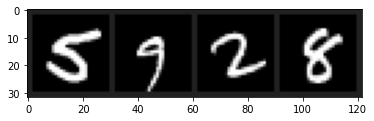

GroundTruth:  5 9 2 8


In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.size())
print(labels.size())

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(labels.size(0))))

## 2. Build a simple CNN

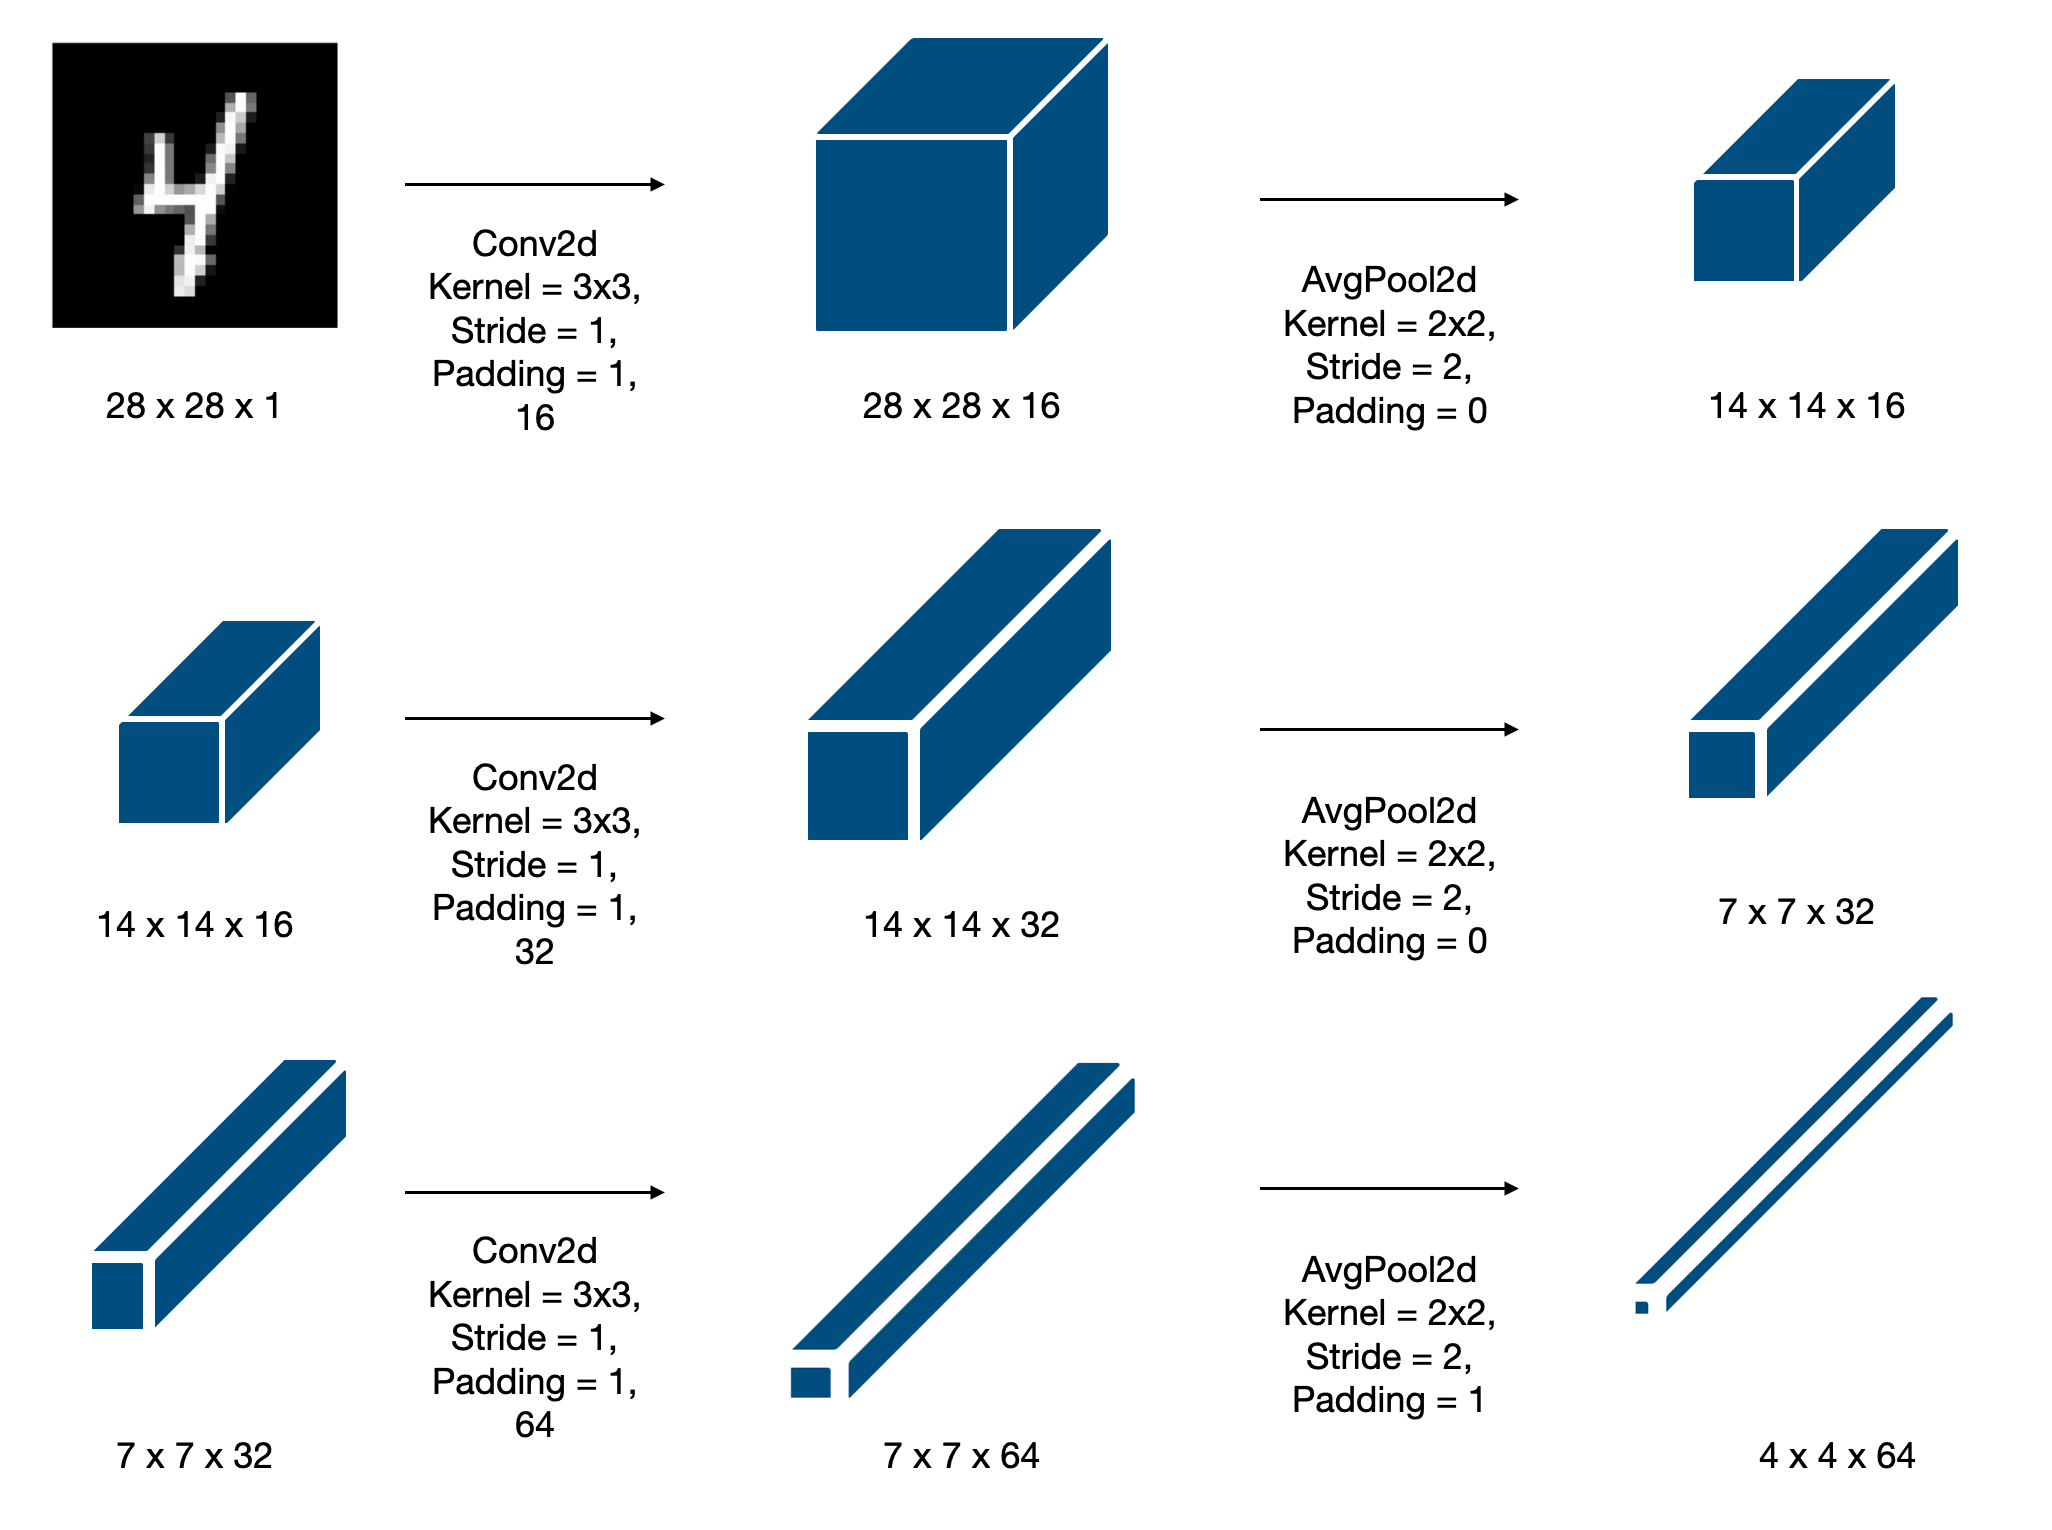

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3,
                               stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                               stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
                               stride=1, padding=1)
        
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=1)

        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.bn3 = nn.BatchNorm2d(num_features=64)

        self.dropout = nn.Dropout(p=0.5)

        self.activation = nn.ReLU()

        self.classifier = nn.Linear(in_features=64*4*4, out_features=num_classes)

    def forward(self, x):
        # print(f'Original input dimension in a format of [B, C, H, W] is {list(x.size())}')
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.avg_pool1(out)
        # Or simply, 
        # out = self.avg_pool1(self.dropout(self.activation(self.bn1(self.conv1(x)))))

        # print(f'After first  [Conv -> BatchNorm -> ReLU -> Dropout -> MaxPool] the dimension of tensor is {list(out.size())}')
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.avg_pool1(out)
        # Or simply,
        # out = self.avg_pool1(self.dropout(self.activation(self.bn2(self.conv2(out)))))

        # print(f'After second [Conv -> BatchNorm -> ReLU -> Dropout -> MaxPool] the dimension of tensor is {list(out.size())}')
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.avg_pool2(out)

        # Or simply,
        # out = self.avg_pool2(self.dropout(self.activation(self.bn3(self.conv3(out)))))

        # Need to flatten the output tensor with the shape of [B, C, H, W] -> [B, N]
        # in order to fed into linear classifier
        # print(f'After thrid  [Conv -> BatchNorm -> ReLU -> Dropout -> MaxPool] the dimension of tensor is {list(out.size())}')

        out = out.view(out.size(0), -1)
        # print(f'Linear layers requires inputs to be [B, N] dimensions')
        out = self.classifier(out)

        return out

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3,
                               stride=1, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.AvgPool2d(kernel_size=2, stride=2),                   
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                               stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
                               stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=1),       
        )

        self.classifier = nn.Linear(in_features=64*4*4, out_features=num_classes)

    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        # Need to flatten the output tensor with the shape of [B, C, H, W] -> [B, N]
        # in order to fed into linear classifier
        out = out.view(out.size(0), -1)
        out = self.classifier(out)

        return out

In [ ]:
cnn = SimpleCNN(in_channels=1, num_classes=10).cuda()
summary(cnn, (1, 28, 28), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
           Dropout-4           [-1, 16, 28, 28]               0
         AvgPool2d-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           4,640
       BatchNorm2d-7           [-1, 32, 14, 14]              64
              ReLU-8           [-1, 32, 14, 14]               0
           Dropout-9           [-1, 32, 14, 14]               0
        AvgPool2d-10             [-1, 32, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          18,496
      BatchNorm2d-12             [-1, 64, 7, 7]             128
             ReLU-13             [-1, 64, 7, 7]               0
          Dropout-14             [-1, 6

##3. Set hyperparameters

- It is necessary to set hyperparameters for training a network.
- We will use Stochastic Gradient Descent (SGD) optimizer to update the weights and Cross-Entropy as a loss function
    - More and detailed PyTorch optimizers can be found [here](https://pytorch.org/docs/stable/optim.html).
    - More and detailed PyTorch loss functions can be found [here](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [ ]:
'''
Set Hyperparameters 

- we will set mini-batch size, number of epochs, learning rate and momentum for using SGD optimizer
'''

lr = 0.001
momentum = 0.9
epochs = 10

##4. 1) Model Training

- For each epoch, we train and validate the model.
- Note that the validation dataset is not included in test set. 
- Here is a simple procedure training a model:


    for each epoch:
        model.train()
        get input and target data from train loader
        
        optmizer.zero_grad()             # reset the gradient 
        pred = model(input)

        loss = criterion(pred, target)   # compute the loss
        loss.backward()                  # backprop
        optimizer.step()                 # update the model weights

        model.eval()                     # set the evaluation mode (turn off batchnorm, dropout)
        with torch.no_grad():
            get the input and target data from validation loader

            pred = model(input)
            compute the validation loss  # Optional 
            calculate the validation accuracy
            save the model w.r.t. validation accuracy


In [ ]:
def train(model, optimizer, criterion, data_loader, epoch):
    model.train()
    total_loss = 0.0
    for idx, batch in enumerate(data_loader):
        img, target = batch[0].cuda(), batch[1].cuda()

        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() 

        if idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, idx * img.size(0), len(data_loader.dataset),
                100. * idx * img.size(0) / len(data_loader.dataset), 
                loss.data))

    return total_loss / len(data_loader)

def validate(model, criterion, data_loader, epoch, highest, fold):
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            img, target = batch[0].cuda(), batch[1].cuda()

            output = model(img)
            loss = criterion(output, target)
            _, predicted = torch.max(output.data, 1)
            val_loss += loss.item()
            val_acc += (predicted == target).sum().item()

        total_val_acc = val_acc / len(data_loader.dataset)
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss / len(data_loader), val_acc, len(data_loader.dataset),
            100. * total_val_acc))
    

    if total_val_acc > highest:
        highest = total_val_acc
        torch.save(model.state_dict(), f'./model_{fold}.pt')
        print(f'Model saved at epoch={epoch + 1} with acc={total_val_acc:.3f}')

    return total_val_acc, highest

In [ ]:
train_losses = []
valid_accs = []

for fold, (train_idx, valid_idx) in enumerate(kfold.split(dataset)):
    print(f'--- Fold {fold} ---')
    train_dataset = Subset(dataset, train_idx)
    valid_dataset = Subset(dataset, valid_idx)

    train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=500, shuffle=False)
    
    cnn = SimpleCNN(in_channels=1, num_classes=10).cuda()
    optimizer = torch.optim.SGD(cnn.parameters(), lr=lr, momentum=momentum)
    criterion = torch.nn.CrossEntropyLoss().cuda()

    train_loss, valid_acc = [], []
    highest = 0.0
    for epoch in range(epochs):
        loss = train(cnn, optimizer, criterion, train_loader, epoch)
        acc, highest = validate(cnn, criterion, valid_loader, epoch, highest, fold)

        train_loss.append(loss)
        valid_acc.append(acc)
    
    train_losses.append(train_loss)
    valid_accs.append(valid_acc)

--- Fold 0 ---
Train Epoch: 1 [0/48000 (0%)]	Loss: 2.359925
Train Epoch: 1 [5000/48000 (10%)]	Loss: 2.293887
Train Epoch: 1 [10000/48000 (21%)]	Loss: 2.216926
Train Epoch: 1 [15000/48000 (31%)]	Loss: 2.147675
Train Epoch: 1 [20000/48000 (42%)]	Loss: 2.074079
Train Epoch: 1 [25000/48000 (52%)]	Loss: 2.014729
Train Epoch: 1 [30000/48000 (62%)]	Loss: 1.910229
Train Epoch: 1 [35000/48000 (73%)]	Loss: 1.811369
Train Epoch: 1 [40000/48000 (83%)]	Loss: 1.752273
Train Epoch: 1 [45000/48000 (94%)]	Loss: 1.660823

Validation set: Average loss: 1.5504, Accuracy: 8728.0/12000 (73%)

Model saved at epoch=0 with acc=0.727
Train Epoch: 2 [0/48000 (0%)]	Loss: 1.604483
Train Epoch: 2 [5000/48000 (10%)]	Loss: 1.527285
Train Epoch: 2 [10000/48000 (21%)]	Loss: 1.493809
Train Epoch: 2 [15000/48000 (31%)]	Loss: 1.429836
Train Epoch: 2 [20000/48000 (42%)]	Loss: 1.392430
Train Epoch: 2 [25000/48000 (52%)]	Loss: 1.293499
Train Epoch: 2 [30000/48000 (62%)]	Loss: 1.251389
Train Epoch: 2 [35000/48000 (73%)]	Loss:

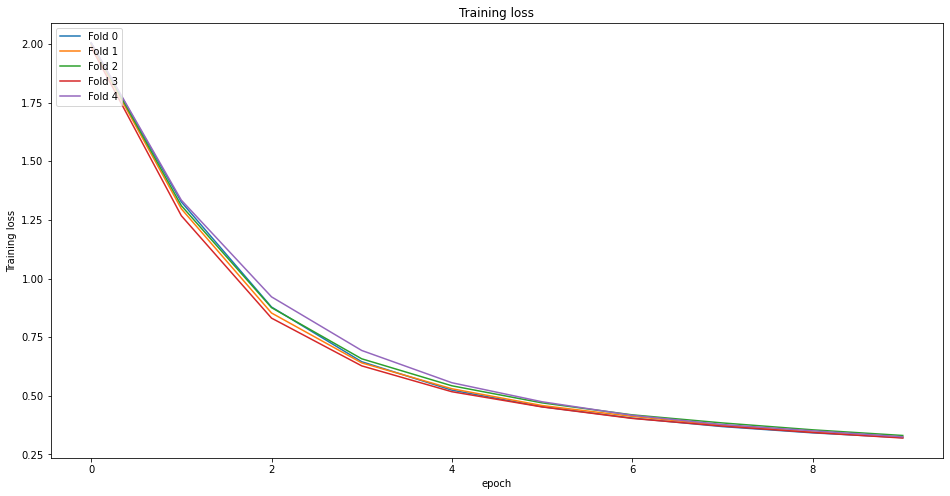

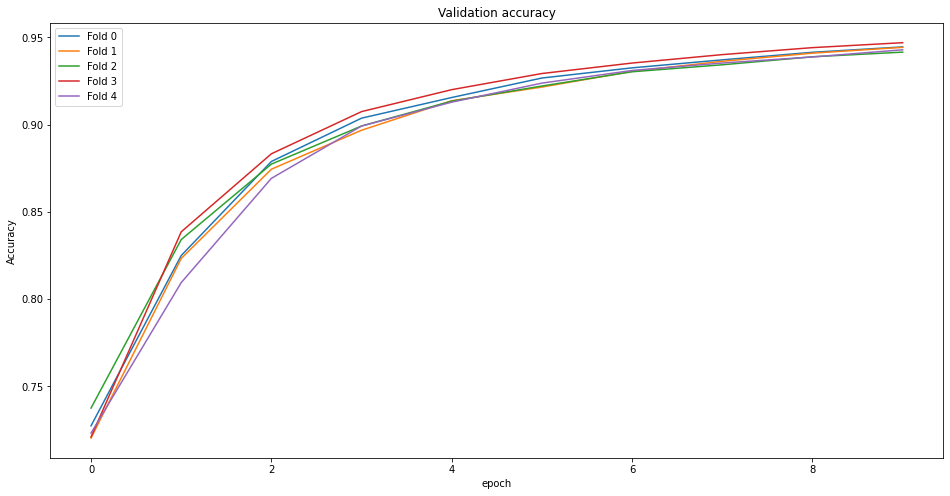

In [ ]:
plt.figure(figsize=(16, 8))

for i in range(len(train_losses)):
    plt.plot(train_losses[i])
    plt.title('Training loss')
    plt.ylabel('Training loss')
    plt.xlabel('epoch')
plt.legend([f'Fold {i}' for i in range(5)], loc='upper left')
plt.show()

plt.figure(figsize=(16, 8))
for i in range(len(valid_accs)):
    plt.plot(valid_accs[i])
    plt.title('Validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
plt.legend([f'Fold {i}' for i in range(5)], loc='upper left')
plt.show()

##4. 2) Model Evaluation

- Evaluation is done as same as validation procedures. 
- Note that we use test dataset not validation dataset.


In [ ]:
def test(model, criterion, data_loader):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            img, target = batch[0].cuda(), batch[1].cuda()

            output = model(img)
            loss = criterion(output, target)
            _, predicted = torch.max(output.data, 1)
            test_loss += loss.item()
            test_acc += (predicted == target).sum().item()

        print('\n Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss  / len(data_loader), test_acc, len(data_loader.dataset),
            100. * test_acc / len(data_loader.dataset)))

    return test_acc / len(data_loader.dataset)

In [ ]:
def test_grad(model, criterion, data_loader):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0

    for idx, batch in enumerate(data_loader):
        img, target = batch[0].cuda(), batch[1].cuda()

        output = model(img)
        loss = criterion(output, target)
        _, predicted = torch.max(output.data, 1)
        test_loss += loss.item()
        test_acc += (predicted == target).sum().item()

    print('\n Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss  / len(data_loader), test_acc, len(data_loader.dataset),
        100. * test_acc / len(data_loader.dataset)))

    return test_acc / len(data_loader.dataset)

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

start.record()
_ = test_grad(cnn, criterion, test_loader)
end.record()
torch.cuda.synchronize()

print(f'Without torch.no_grad(), it takes {start.elapsed_time(end):.3f} miliseconds')


 Test set: Average loss: 0.2075, Accuracy: 9501.0/10000 (95%)

Without torch.no_grad(), it takes 1815.466 miliseconds


In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

start.record()
_ = test(cnn, criterion, test_loader)
end.record()
torch.cuda.synchronize()

print(f'With torch.no_grad(), it takes {start.elapsed_time(end):.3f} miliseconds')


 Test set: Average loss: 0.2075, Accuracy: 9501.0/10000 (95%)

With torch.no_grad(), it takes 1792.820 miliseconds


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_accs = []

for i in range(5):
    cnn = SimpleCNN(in_channels=1, num_classes=10).cuda()
    cnn.load_state_dict(torch.load(f'./model_{i}.pt'))
    test_acc = test(cnn, criterion, test_loader)
    
    test_accs.append(test_acc)

print(f"Average test accuracy is {sum(test_accs) / 5 :.3f}")


 Test set: Average loss: 0.2115, Accuracy: 9494.0/10000 (95%)


 Test set: Average loss: 0.2144, Accuracy: 9494.0/10000 (95%)


 Test set: Average loss: 0.2204, Accuracy: 9461.0/10000 (95%)


 Test set: Average loss: 0.2086, Accuracy: 9496.0/10000 (95%)


 Test set: Average loss: 0.2075, Accuracy: 9501.0/10000 (95%)

Average test accuracy is 0.949


#2. Kaggle Dataset

- Although simple datasets are provided by PyTorch, constructing own custom dataset is the most difficult and time-consuming part in deep learning.

- Therefore, we will use *somewhat* raw data and train a model.

- We will use [100 Sports Image Classification](https://www.kaggle.com/datasets/gpiosenka/sports-classification) dataset which contains 13,572 training data, 500 validation and 500 test data with the shape of [H, W, C] = [224, 244, 3] in jpeg format.

- Since the structure of dataset is constructed as the subfolders of each class with image, there are two ways we can construct dataset as follows:
    - Building custom dataset 
    - Use `torch.utils.data.DataFolder`

`TODO: Add a brief explanation why we need to make custom dataset`

In [ ]:
!pip install gdown && gdown https://drive.google.com/uc?id=1rctM1HDoc24XOcRzsYyTSavaFrvuoKZc && unzip /content/archive.zip -d /content/sports

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/sports/train/rings/058.jpg  
  inflating: /content/sports/train/rings/059.jpg  
  inflating: /content/sports/train/rings/060.jpg  
  inflating: /content/sports/train/rings/061.jpg  
  inflating: /content/sports/train/rings/062.jpg  
  inflating: /content/sports/train/rings/063.jpg  
  inflating: /content/sports/train/rings/064.jpg  
  inflating: /content/sports/train/rings/065.jpg  
  inflating: /content/sports/train/rings/066.jpg  
  inflating: /content/sports/train/rings/067.jpg  
  inflating: /content/sports/train/rings/068.jpg  
  inflating: /content/sports/train/rings/069.jpg  
  inflating: /content/sports/train/rings/070.jpg  
  inflating: /content/sports/train/rings/071.jpg  
  inflating: /content/sports/train/rings/072.jpg  
  inflating: /content/sports/train/rings/073.jpg  
  inflating: /content/sports/train/rings/074.jpg  
  inflating: /content/sports/train/rings/075.jpg  
  inflating: /content/sports/train/rings/076.j

### Custom Dataset can be constructed as follows:


```
class CustomDataset(torch.utils.data.Dataset):
    # Inherit torch.utils.data.Dataset class

    def __init__(self,):
        # Initialize the dataset (handling data paths, check input and target data, data augmentation, etc.)

    def __len__(self):
        # Return the number of data or sample in dataset 
    
    def __getitem__(self, index):
        # Return the input and target by index
```

- Further information, please refer [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

- This will be your assignment!

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_dataset = SportsDataset(train_files, class_dict, train_transforms)
valid_dataset = SportsDataset(valid_files, class_dict, test_transforms)
test_dataset = SportsDataset(test_files, class_dict, test_transforms)

- However, dataset constructed with folders (classes) with each items, we can easily construct dataset using `torch.utils.data.ImageFolder()` as follows:

In [ ]:
train_dataset = ImageFolder('./sports/train', transform=transforms.ToTensor())
valid_dataset = ImageFolder('./sports/valid', transform=transforms.ToTensor())
test_dataset = ImageFolder('./sports/test', transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

torch.Size([4, 3, 224, 224])
torch.Size([4])


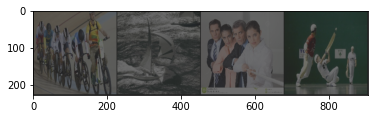

GroundTruth:  nascar racing baton twirling volleyball judo


In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.size())
print(labels.size())

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(labels.size(0))))

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_dataset = ImageFolder('./sports/train', transform=train_transforms)
valid_dataset = ImageFolder('./sports/valid', transform=test_transforms)
test_dataset = ImageFolder('./sports/test', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Get the model from `torchvision.models`

- We will use ResNet50 and DenseNet121 with and without pretrained weights on ImageNet-1K.

- Please refer to further information on `torchvision.models` [here](https://pytorch.org/vision/stable/models.html).

In [ ]:
from torchvision.models import resnet50, densenet121

resnet50_scratch = resnet50(weights=None, num_classes=100)
densenet121_scratch = densenet121(weights=None, num_classes=100)

In [ ]:
pprint(resnet50_scratch)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
pprint(densenet121_scratch)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
model = resnet50_scratch.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss().cuda()

In [ ]:
def train(model, optimizer, criterion, data_loader, epoch):
    model.train()
    total_loss = 0.0
    for idx, batch in enumerate(data_loader):
        img, target = batch[0].cuda(), batch[1].cuda()

        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() 

        if idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, idx * img.size(0), len(data_loader.dataset),
                100. * idx * img.size(0) / len(data_loader.dataset), 
                loss.data))

    return total_loss / len(data_loader)

def validate(model, criterion, data_loader, epoch, highest, model_name):
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            img, target = batch[0].cuda(), batch[1].cuda()

            output = model(img)
            loss = criterion(output, target)
            _, predicted = torch.max(output.data, 1)
            val_loss += loss.item()
            val_acc += (predicted == target).sum().item()

        total_val_acc = val_acc / len(data_loader.dataset)
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss / len(data_loader), val_acc, len(data_loader.dataset),
            100. * total_val_acc))
    

    if total_val_acc > highest:
        highest = total_val_acc
        torch.save(model.state_dict(), f'./{model_name}.pt')
        print(f'Model saved at epoch={epoch + 1} with acc={total_val_acc:.3f}')

    return total_val_acc, highest

- Training ResNet-50 from scratch!

In [ ]:
metric_dict = {}
epochs = 10

In [ ]:
train_loss = []
valid_acc = []

model = resnet50_scratch.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss().cuda()

highest = 0.0
for epoch in range(epochs):
    loss = train(model, optimizer, criterion, train_loader, epoch)
    acc, highest = validate(model, criterion, valid_loader, epoch, highest, model_name='resnet50_scratch')

    train_loss.append(loss)
    valid_acc.append(acc)

metric_dict.update(
    {"resnet50_scratch": {
        "train_loss": train_loss, 
        "valid_acc" : valid_acc}},
)

Train Epoch: 1 [0/13572 (0%)]	Loss: 4.816245
Train Epoch: 1 [640/13572 (5%)]	Loss: 5.082251
Train Epoch: 1 [1280/13572 (9%)]	Loss: 4.811006
Train Epoch: 1 [1920/13572 (14%)]	Loss: 4.858334
Train Epoch: 1 [2560/13572 (19%)]	Loss: 4.333560
Train Epoch: 1 [3200/13572 (24%)]	Loss: 4.504637
Train Epoch: 1 [3840/13572 (28%)]	Loss: 4.303590
Train Epoch: 1 [4480/13572 (33%)]	Loss: 4.160914
Train Epoch: 1 [5120/13572 (38%)]	Loss: 3.954141
Train Epoch: 1 [5760/13572 (42%)]	Loss: 3.908262
Train Epoch: 1 [6400/13572 (47%)]	Loss: 4.005600
Train Epoch: 1 [7040/13572 (52%)]	Loss: 4.002015
Train Epoch: 1 [7680/13572 (57%)]	Loss: 3.835959
Train Epoch: 1 [8320/13572 (61%)]	Loss: 3.913559
Train Epoch: 1 [8960/13572 (66%)]	Loss: 3.868722
Train Epoch: 1 [9600/13572 (71%)]	Loss: 3.834793
Train Epoch: 1 [10240/13572 (75%)]	Loss: 3.736577
Train Epoch: 1 [10880/13572 (80%)]	Loss: 3.887407
Train Epoch: 1 [11520/13572 (85%)]	Loss: 3.974472
Train Epoch: 1 [12160/13572 (90%)]	Loss: 3.653011
Train Epoch: 1 [12800/1

In [ ]:
test(model, criterion, test_loader)


 Test set: Average loss: 0.2347, Accuracy: 467.0/500 (93%)



0.934

In [ ]:
model.load_state_dict(torch.load('/content/resnet50_scratch.pt'))
test(model, criterion, test_loader)

- Train DenseNet-121 from scratch!

In [ ]:
train_loss = []
valid_acc = []

model = densenet121_scratch.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss().cuda()

highest = 0.0
for epoch in range(epochs):
    loss = train(model, optimizer, criterion, train_loader, epoch)
    acc, highest = validate(model, criterion, valid_loader, epoch, highest, model_name='densenet121_scratch')

    train_loss.append(loss)
    valid_acc.append(acc)

metric_dict.update(
    {"densenet121_scratch": {
        "train_loss": train_loss, 
        "valid_acc" : valid_acc}},
)

Train Epoch: 1 [0/13572 (0%)]	Loss: 4.626671
Train Epoch: 1 [640/13572 (5%)]	Loss: 4.468911
Train Epoch: 1 [1280/13572 (9%)]	Loss: 4.045377
Train Epoch: 1 [1920/13572 (14%)]	Loss: 3.869287
Train Epoch: 1 [2560/13572 (19%)]	Loss: 3.817825
Train Epoch: 1 [3200/13572 (24%)]	Loss: 3.989377
Train Epoch: 1 [3840/13572 (28%)]	Loss: 3.774751
Train Epoch: 1 [4480/13572 (33%)]	Loss: 3.804507
Train Epoch: 1 [5120/13572 (38%)]	Loss: 3.752324
Train Epoch: 1 [5760/13572 (42%)]	Loss: 3.377069
Train Epoch: 1 [6400/13572 (47%)]	Loss: 3.489620
Train Epoch: 1 [7040/13572 (52%)]	Loss: 3.337809
Train Epoch: 1 [7680/13572 (57%)]	Loss: 3.339797
Train Epoch: 1 [8320/13572 (61%)]	Loss: 3.504602
Train Epoch: 1 [8960/13572 (66%)]	Loss: 3.318557
Train Epoch: 1 [9600/13572 (71%)]	Loss: 3.655970
Train Epoch: 1 [10240/13572 (75%)]	Loss: 3.465665
Train Epoch: 1 [10880/13572 (80%)]	Loss: 3.109852
Train Epoch: 1 [11520/13572 (85%)]	Loss: 3.554933
Train Epoch: 1 [12160/13572 (90%)]	Loss: 3.232467
Train Epoch: 1 [12800/1

In [ ]:
test(model, criterion, test_loader)


 Test set: Average loss: 0.2347, Accuracy: 467.0/500 (93%)



0.934

In [ ]:
model.load_state_dict(torch.load('/content/densenet121_scratch.pt'))
test(model, criterion, test_loader)


 Test set: Average loss: 1.2800, Accuracy: 312.0/500 (62%)



0.624

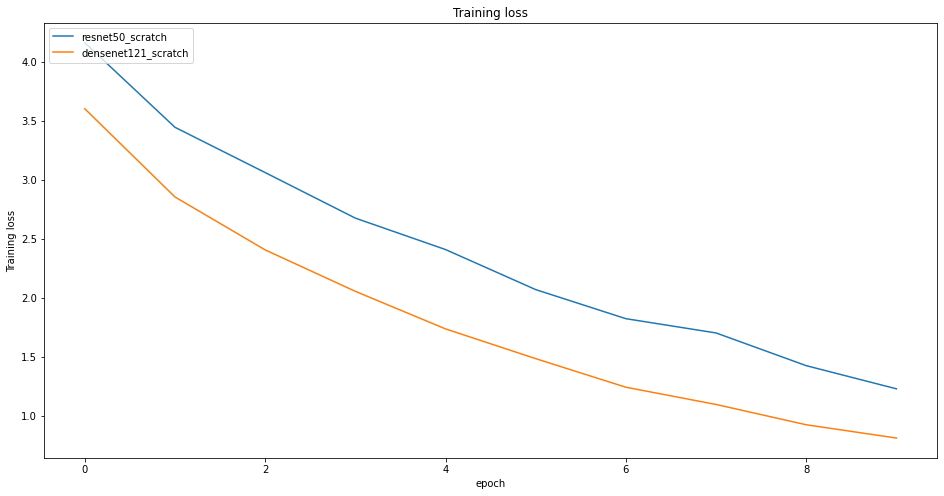

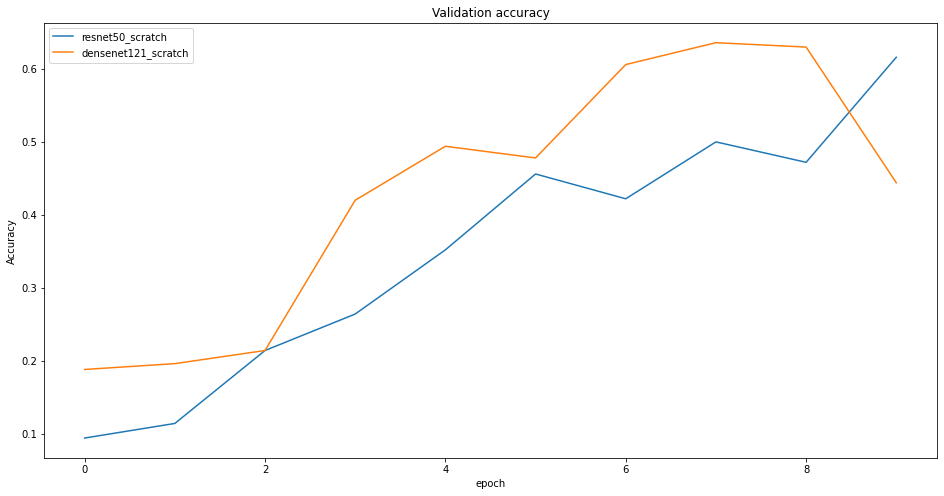

In [ ]:
plt.figure(figsize=(16, 8))

model_name = ['resnet50_scratch', 'densenet121_scratch']

for i in range(len(model_name)):
    plt.plot(metric_dict[model_name[i]]['train_loss'])
    plt.title('Training loss')
    plt.ylabel('Training loss')
    plt.xlabel('epoch')

plt.legend([f'{name}' for name in model_name], loc='upper left')
plt.show()

plt.figure(figsize=(16, 8))
for i in range(len(model_name)):
    plt.plot(metric_dict[model_name[i]]['valid_acc'])
    plt.title('Validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')

plt.legend([f'{name}' for name in model_name], loc='upper left')
plt.show()

## Transfer learning with pretrained weights

1. *Initialize the model* with pretrained weights (a.k.a **finetuning**) - update all the parameters including convolution layers and fully connected layer.

2. *Freeze the pretrained convolution layers* (a.k.a **feature extraction**) - update only the last fully connected layer by turning off the gradient update on convolution layers.

### 1. Finetuning

In [ ]:
resnet50_finetuning = resnet50(weights='IMAGENET1K_V1')
pprint(resnet50_finetuning.fc)
num_features = resnet50_finetuning.fc.in_features

resnet50_finetuning.fc = nn.Linear(num_features, 100)

pprint(resnet50_finetuning.fc)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Linear(in_features=2048, out_features=1000, bias=True)
Linear(in_features=2048, out_features=100, bias=True)


In [ ]:
train_loss = []
valid_acc = []

model = resnet50_finetuning.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss().cuda()

highest = 0.0
for epoch in range(epochs):
    loss = train(model, optimizer, criterion, train_loader, epoch)
    acc, highest = validate(model, criterion, valid_loader, epoch, highest, model_name='resnet50_finetuning')

    train_loss.append(loss)
    valid_acc.append(acc)

metric_dict.update(
    {"resnet50_finetuning": {
        "train_loss": train_loss, 
        "valid_acc" : valid_acc}},
)

Train Epoch: 1 [0/13572 (0%)]	Loss: 4.673883
Train Epoch: 1 [640/13572 (5%)]	Loss: 3.950288
Train Epoch: 1 [1280/13572 (9%)]	Loss: 3.550412
Train Epoch: 1 [1920/13572 (14%)]	Loss: 2.792980
Train Epoch: 1 [2560/13572 (19%)]	Loss: 2.786387
Train Epoch: 1 [3200/13572 (24%)]	Loss: 2.675617
Train Epoch: 1 [3840/13572 (28%)]	Loss: 2.097179
Train Epoch: 1 [4480/13572 (33%)]	Loss: 2.162880
Train Epoch: 1 [5120/13572 (38%)]	Loss: 1.855440
Train Epoch: 1 [5760/13572 (42%)]	Loss: 1.872422
Train Epoch: 1 [6400/13572 (47%)]	Loss: 1.954520
Train Epoch: 1 [7040/13572 (52%)]	Loss: 2.145522
Train Epoch: 1 [7680/13572 (57%)]	Loss: 1.596736
Train Epoch: 1 [8320/13572 (61%)]	Loss: 1.655790
Train Epoch: 1 [8960/13572 (66%)]	Loss: 1.541998
Train Epoch: 1 [9600/13572 (71%)]	Loss: 1.496293
Train Epoch: 1 [10240/13572 (75%)]	Loss: 1.945469
Train Epoch: 1 [10880/13572 (80%)]	Loss: 1.994354
Train Epoch: 1 [11520/13572 (85%)]	Loss: 1.667613
Train Epoch: 1 [12160/13572 (90%)]	Loss: 1.275845
Train Epoch: 1 [12800/1

In [ ]:
test(model, criterion, test_loader)


 Test set: Average loss: 0.5137, Accuracy: 429.0/500 (86%)



0.858

In [ ]:
model.load_state_dict(torch.load('/content/resnet50_finetuning.pt'))
test(model, criterion, test_loader)


 Test set: Average loss: 0.5137, Accuracy: 429.0/500 (86%)



0.858

In [ ]:
densenet121_finetuning = densenet121(weights='IMAGENET1K_V1')
pprint(densenet121_finetuning.classifier)
num_features = densenet121_finetuning.classifier.in_features

densenet121_finetuning.classifier = nn.Linear(num_features, 100)

pprint(densenet121_finetuning.classifier)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Linear(in_features=1024, out_features=1000, bias=True)
Linear(in_features=1024, out_features=100, bias=True)


In [ ]:
train_loss = []
valid_acc = []

model = densenet121_finetuning.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss().cuda()

highest = 0.0
for epoch in range(epochs):
    loss = train(model, optimizer, criterion, train_loader, epoch)
    acc, hightest = validate(model, criterion, valid_loader, epoch, highest, model_name='densenet121_finetuning')

    train_loss.append(loss)
    valid_acc.append(acc)

metric_dict.update(
    {"densenet121_finetuning": {
        "train_loss": train_loss, 
        "valid_acc" : valid_acc}},
)

Train Epoch: 1 [0/13572 (0%)]	Loss: 4.740613
Train Epoch: 1 [640/13572 (5%)]	Loss: 3.692171
Train Epoch: 1 [1280/13572 (9%)]	Loss: 2.818820
Train Epoch: 1 [1920/13572 (14%)]	Loss: 2.092419
Train Epoch: 1 [2560/13572 (19%)]	Loss: 2.010639
Train Epoch: 1 [3200/13572 (24%)]	Loss: 2.020958
Train Epoch: 1 [3840/13572 (28%)]	Loss: 1.471338
Train Epoch: 1 [4480/13572 (33%)]	Loss: 1.543166
Train Epoch: 1 [5120/13572 (38%)]	Loss: 1.258099
Train Epoch: 1 [5760/13572 (42%)]	Loss: 1.078053
Train Epoch: 1 [6400/13572 (47%)]	Loss: 1.264371
Train Epoch: 1 [7040/13572 (52%)]	Loss: 1.092545
Train Epoch: 1 [7680/13572 (57%)]	Loss: 0.980262
Train Epoch: 1 [8320/13572 (61%)]	Loss: 1.003554
Train Epoch: 1 [8960/13572 (66%)]	Loss: 1.069472
Train Epoch: 1 [9600/13572 (71%)]	Loss: 1.076105
Train Epoch: 1 [10240/13572 (75%)]	Loss: 0.802672
Train Epoch: 1 [10880/13572 (80%)]	Loss: 0.943369
Train Epoch: 1 [11520/13572 (85%)]	Loss: 0.816047
Train Epoch: 1 [12160/13572 (90%)]	Loss: 0.865056
Train Epoch: 1 [12800/1

In [ ]:
test(model, criterion, test_loader)


 Test set: Average loss: 0.2347, Accuracy: 467.0/500 (93%)



0.934

In [ ]:
model.load_state_dict(torch.load('/content/densenet121_finetuning.pt'))
test(model, criterion, test_loader)


 Test set: Average loss: 0.2347, Accuracy: 467.0/500 (93%)



0.934

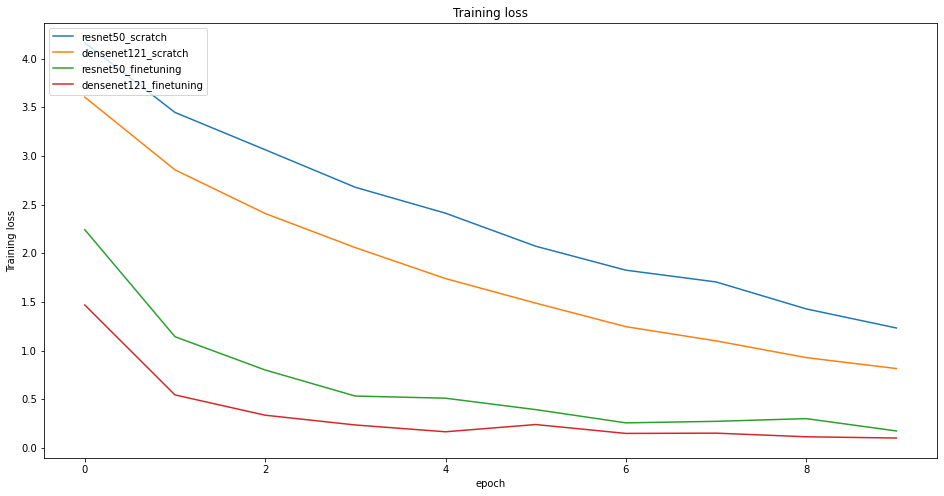

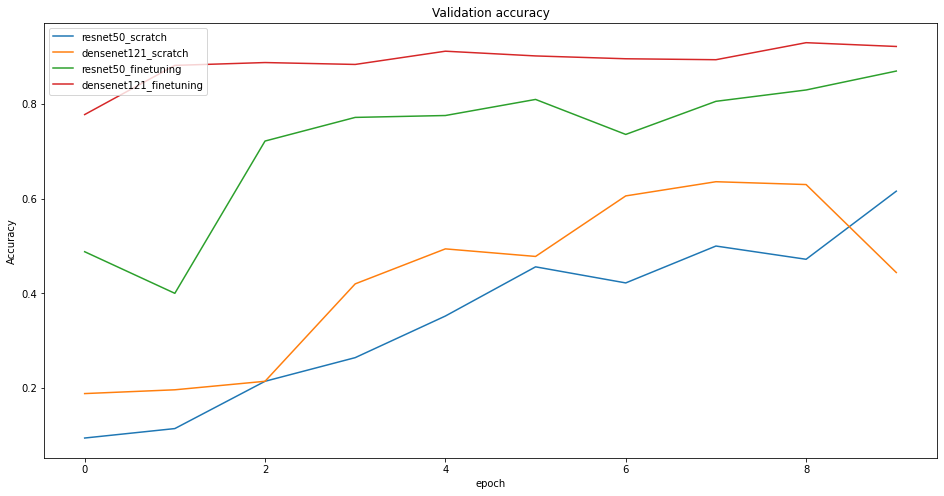

In [ ]:
plt.figure(figsize=(16, 8))

model_name = ['resnet50_scratch', 'densenet121_scratch', 'resnet50_finetuning', 'densenet121_finetuning']

for i in range(len(model_name)):
    plt.plot(metric_dict[model_name[i]]['train_loss'])
    plt.title('Training loss')
    plt.ylabel('Training loss')
    plt.xlabel('epoch')

plt.legend([f'{name}' for name in model_name], loc='upper left')
plt.show()

plt.figure(figsize=(16, 8))
for i in range(len(model_name)):
    plt.plot(metric_dict[model_name[i]]['valid_acc'])
    plt.title('Validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')

plt.legend([f'{name}' for name in model_name], loc='upper left')
plt.show()

###2. Feature Extractor

In [ ]:
resnet50_feature_extractor = resnet50(weights='IMAGENET1K_V1')

for name, param in resnet50_feature_extractor.named_parameters():
    # print(name, param.requires_grad)
    param.requires_grad = False

num_features = resnet50_feature_extractor.fc.in_features

resnet50_feature_extractor.fc = nn.Linear(num_features, 100)


In [ ]:
train_loss = []
valid_acc = []

model = resnet50_feature_extractor.cuda()

# Note that we only need to pass the parameters we want to update
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss().cuda()

highest = 0.0
for epoch in range(epochs):
    loss = train(model, optimizer, criterion, train_loader, epoch)
    acc, highest = validate(model, criterion, valid_loader, epoch, highest, model_name='resnet50_feature')

    train_loss.append(loss)
    valid_acc.append(acc)

metric_dict.update(
    {"resnet50_feature_extractor": {
        "train_loss": train_loss, 
        "valid_acc" : valid_acc}},
)

In [ ]:
test(model, criterion, test_loader)

In [ ]:
model.load_state_dict(torch.load(''))
test(model, criterion, test_loader)

In [ ]:
densenet121_feature_extractor = densenet121(weights='IMAGENET1K_V1')

for name, param in densenet121_feature_extractor.named_parameters():
    print(name, param.requires_grad)
    param.requires_grad = False
    print(name, param.requires_grad)

pprint(densenet121_feature_extractor.classifier)
num_features = densenet121_feature_extractor.classifier.in_features

densenet121_feature_extractor.classifier = nn.Linear(num_features, 100)

pprint(densenet121_feature_extractor.classifier)

In [ ]:
train_loss = []
valid_acc = []

model = densenet121_feature_extractor.cuda()

# Note that we only need to pass the parameters we want to update
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss().cuda()

highest = 0.0
for epoch in range(epochs):
    loss = train(model, optimizer, criterion, train_loader, epoch)
    acc, highest = validate(model, criterion, valid_loader, epoch, highest, model_name='densenet121_feature')

    train_loss.append(loss)
    valid_acc.append(acc)

metric_dict.update(
    {"densenet121_feature_extractor": {
        "train_loss": train_loss, 
        "valid_acc" : valid_acc}},
)

In [ ]:
test(model, criterion, test_loader)

In [ ]:
model.load_state_dict(torch.load(''))
test(model, criterion, test_loader)

In [ ]:
plt.figure(figsize=(16, 8))

model_name = ['resnet50_finetuning', 'densenet121_finetuning', 'resnet50_feature_extractor', 'densenet121_feature_extractor']

for i in range(len(model_name)):
    plt.plot(metric_dict[model_name[i]]['train_loss'])
    plt.title('Training loss')
    plt.ylabel('Training loss')
    plt.xlabel('epoch')

plt.legend([f'{name}' for name in model_name], loc='upper left')
plt.show()

plt.figure(figsize=(16, 8))
for i in range(len(model_name)):
    plt.plot(metric_dict[model_name[i]]['valid_acc'])
    plt.title('Validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')

plt.legend([f'{name}' for name in model_name], loc='upper left')
plt.show()

#3. References

- Kaggle 100 Sports Image Classification - https://www.kaggle.com/datasets/gpiosenka/sports-classification
- Introduction to PyTorch - https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
- Torchvision models description - https://pytorch.org/vision/stable/models.html
- PyTorch transfer learning tutorial - https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- Stanford CS231n course notes - https://cs231n.github.io/
- [Korean] PyTorch로 시작하는 딥 러닝 입문 - https://wikidocs.net/book/2788
